Brownian Motion
===============

This is an attempt at a better understanding of our new metrics of molecular motion,
namely how they relate to each other when Brownian Dynamics are observed.
This notebook implements Brownian dynamics using the recipie from the [scipy cookbook]( http://scipy-cookbook.readthedocs.io/items/BrownianMotion.html),
then uses the simulation of Brownian motion to investigate
how the molecular relaxation times respond.

Implementation
--------------

The code in the cell below implements the brownian dynamics.
For 2D brownian dynamics, x0 with 2 elements can be used as the input. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import altair as alt
import itertools
import scipy.stats

from sdanalysis import dynamics

import sys
sys.path.append("../src")

from brownian import brownian

alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

### Testing Brownian Dynamics

This is a simple test case of the function to Generate the Brownian dynamics
ensuring that the resulting trajectory is sensible,
and to give some idea of the spread of values.

In [2]:
# The Wiener process parameter.
delta = 0.25
# Total time.
T = 10.0
# Number of steps.
N = 1000
# Time step size
dt = T/N
# Initial values of x.
x = np.empty((2,N+1))
x[:, 0] = 0.0

brownian(x[:,0], N, dt, delta, out=x[:,1:])

array([[0.02757211, 0.04044362, 0.02920026, ..., 2.13357581, 2.11906103,
        2.13452817],
       [0.03208098, 0.056087  , 0.06476525, ..., 0.68062694, 0.70208182,
        0.714517  ]])

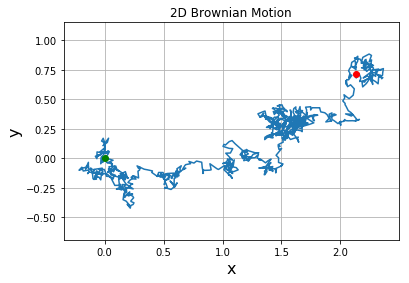

In [3]:
# Plot the 2D trajectory.
plt.plot(x[0],x[1])

# Mark the start and end points.
plt.plot(x[0,0],x[1,0], 'go')
plt.plot(x[0,-1], x[1,-1], 'ro')

# More plot decorations.
plt.title('2D Brownian Motion')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.axis('equal')
plt.grid(True)
plt.show()

Dynamics Analysis
-----------------

Now we have a function to generate brownian dynamics,
I want to use it to  

In [4]:
nsteps = 1000
T = 40.0
delta_param = 0.25
num_mols = 2000


def get_relax():
    relax = []
    for mol in range(num_mols):
        delta = np.linalg.norm(brownian(np.zeros((2)), nsteps, T/nsteps, delta_param), axis=0)
        delta = delta.reshape((-1, 1))
        tau_F = dynamics.MolecularRelaxation(1, 0.4)
        tau_L = dynamics.LastMolecularRelaxation(1, 0.4, 1.0)
        for time, dist in enumerate(delta):
            tau_F.add(time, dist)
            tau_L.add(time, dist)
        relax.append({
            'tau_L': tau_L.get_status()[0],
            'tau_F': tau_F.get_status()[0],
        })
    return relax
relax = get_relax()

In [5]:
brownian_relation = pandas.DataFrame.from_records(relax)
brownian_relation = brownian_relation[brownian_relation.tau_L != 2**32-1]

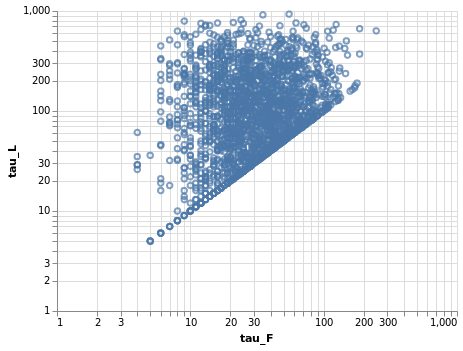

In [6]:
c = alt.Chart(brownian_relation).mark_point().encode(
    x=alt.X('tau_F', scale=alt.Scale(type='log')),
    y=alt.Y('tau_L', scale=alt.Scale(type='log')),
)
c

In [7]:
df = brownian_relation[['tau_L', 'tau_F']]
df.reset_index(drop=True, inplace=True)
for x1, x2 in itertools.combinations(df.columns, 2):
    correlation, pValue = scipy.stats.pearsonr(getattr(df, x1), getattr(df, x2))
    print(f'{x1: <8} {x2: <8} {correlation:.2f}')

tau_L    tau_F    0.18


In [16]:
brownian_relation = brownian_relation.loc[:, ['tau_L', 'tau_F']]
brownian_relation['dataset'] = 'Brownian'

df = pandas.read_hdf('../data/analysis/dynamics.h5', 'molecular_relaxations')

lowT_df = df.query("pressure == 13.50 and temperature == 1.30")[["tau_DL04", "tau_D04"]]
lowT_df.columns = ["tau_L", "tau_F"]
lowT_df['dataset'] = 'Low T'
lowT_df.reset_index(inplace=True)

highT_df = df.query("pressure == 13.50 and temperature == 2.50")[["tau_DL04", "tau_D04"]]
highT_df.columns = ["tau_L", "tau_F"]
highT_df['dataset'] = 'High T'
highT_df.reset_index(inplace=True)

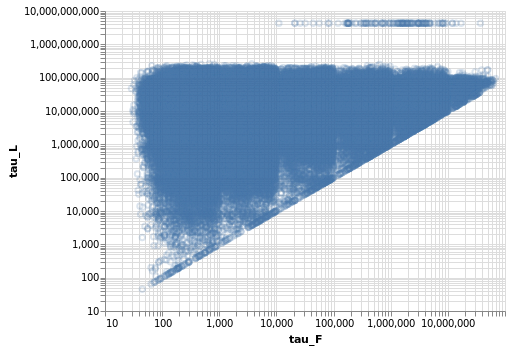

In [18]:
c = alt.Chart(lowT_df).mark_point(opacity=0.2).encode(
    x=alt.X('tau_F', scale=alt.Scale(type='log')),
    y=alt.Y('tau_L', scale=alt.Scale(type='log')),
)
c

In [15]:
c = alt.Chart(lowT_df).mark_point(opacity=0.2).encode(
    x=alt.X('tau_F', scale=alt.Scale(type='log')),
    y=alt.Y('tau_L', scale=alt.Scale(type='log')),
)
c

tau_L    tau_F dataset
0   0    88000000   140000   Low T
    1       61000     2100   Low T
    2     1300000   130000   Low T
    3    57000000      830   Low T
    4       95000      550   Low T
    5    99000000    81000   Low T
    6      730000      390   Low T
    7    47000000    37000   Low T
    8     4600000     2700   Low T
    9      950000    65000   Low T
    10    2400000     2800   Low T
    11    1900000      580   Low T
    12     810000      450   Low T
    13    2100000     7200   Low T
    14    1800000      450   Low T
    15       3300     1100   Low T
    16    5900000      740   Low T
    17      83000    80000   Low T
    18    3500000     3100   Low T
    19      66000      900   Low T
    20   14000000     9000   Low T
    21   95000000      190   Low T
    22     220000      860   Low T
    23   22000000    67000   Low T
    24   11000000     2800   Low T
    25     660000      760   Low T
    26    9800000     2100   Low T
    27    4100000     4300   Low T
    28   26000000    83000   Low T
    29     350000     2600   Low T
...           ...      ...     ...
499 595   2800000     6900   Low T
    596   5200000    78000   Low T
    597  97000000      990   Low T
    598  97000000   480000   Low T
    599  22000000      540   Low T
    600  16000000     3600   Low T
    601  27000000      800   Low T
    602     57000      590   Low T
    603  74000000     3500   Low T
    604  28000000    35000   Low T
    605  20000000  3000000   Low T
    606  21000000   450000   Low T
    607   9000000      470   Low T
    608  12000000      410   Low T
    609   4000000      650   Low T
    610  51000000      250   Low T
    611   3400000     1100   Low T
    612   2500000      410   Low T
    613   3700000      210   Low T
    614  25000000      720   Low T
    615  31000000      580   Low T
    616   3700000      460   Low T
    617   8600000     4400   Low T
    618  28000000      790   Low T
    619  12000000      470   Low T
    620  22000000      650   Low T
    621    880000      500   Low T
    622  28000000      700   Low T
    623   2700000      860   Low T
    624   9900000    46000   Low T

[312500 rows x 3 columns]

In [21]:
num_samples = 1300 #len(brownian_relation)
df = pandas.concat([brownian_relation.sample(num_samples), lowT_df.sample(num_samples), highT_df.sample(num_samples)], sort=True)
df.reset_index(drop=True, inplace=True)

In [22]:
df['diffs'] = df.tau_L - df.tau_F
df['log_diffs'] = np.log10(df.diffs[df.diffs > 0])
df['log_tau_F'] = np.log10(df.tau_F)

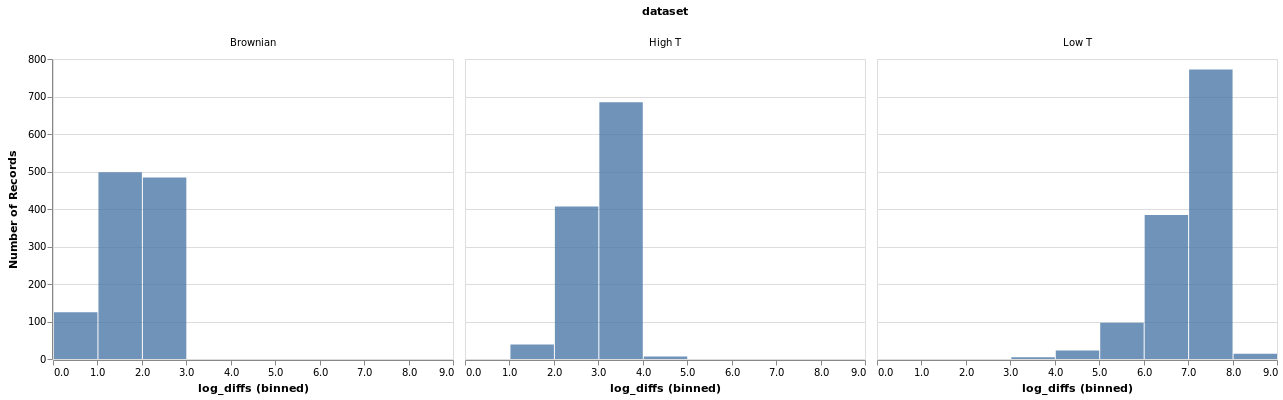

In [23]:
alt.Chart(df).mark_bar(opacity=0.8).encode(
    x=alt.X('log_diffs:Q', bin=alt.Bin()),
    y = alt.Y('count()', stack=None),
#     color = alt.Color('log_tau_F:N', bin=alt.Bin(maxbins=10)),
    column='dataset',
)

In [24]:
c = alt.Chart(df).mark_line().encode(
    x=alt.X('log_diff:Q', axis=alt.Axis(title='log(τ_L - τ_F)'), bin=alt.Bin(maxbins=40)),
    y=alt.Y('count(tau_F_binned):Q', axis=alt.Axis(title='Probability'), stack=None),
    color=alt.Color('tau_F_binned:N', legend=alt.Legend(title='log(τ_F)')),
    column=alt.Column('dataset', header=alt.Header(title='Dataset')),
).transform_calculate(
    'log_diff', "datum.tau_L == datum.tau_F ? NaN : log(datum.tau_L + datum.tau_F) / LN10"
).transform_calculate(
    'log_tau_F', 'log(datum.tau_F) / LN10'
).transform_bin(
    **{'bin': True, 'field': '', 'as': 'tau_F_binned'}
)
c

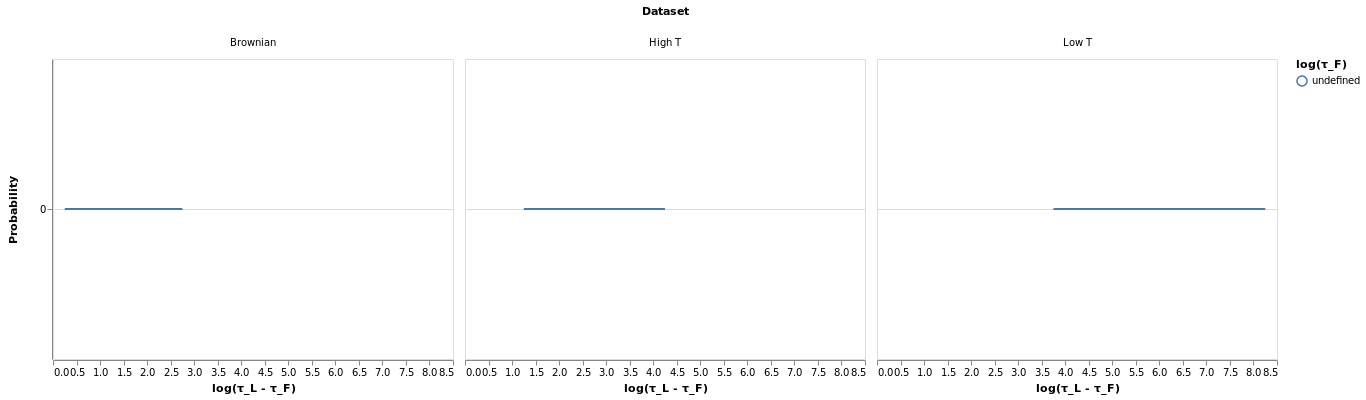

In [25]:
c = alt.Chart(df).mark_line().encode(
    x=alt.X('log_diff:Q', axis=alt.Axis(title='log(τ_L - τ_F)'), bin=alt.Bin(maxbins=40)),
    y=alt.Y('sum(factor):Q', axis=alt.Axis(title='Probability'), stack=None),
    color=alt.Color('log_tau_F_value:N', legend=alt.Legend(title='log(τ_F)')),
    column=alt.Column('dataset', header=alt.Header(title='Dataset')),
).transform_calculate(
    'log_diff', "datum.tau_L == datum.tau_F ? NaN : log(datum.tau_L - datum.tau_F) / LN10"
)
c